In [1]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict, List
from pydantic import BaseModel, Field
from transformers import pipeline
import torch
import os
from dotenv import load_dotenv, find_dotenv
from IPython.display import Image, display

c:\Users\zikri\anaconda3\envs\textgen\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())

True


In [3]:
_ = load_dotenv(find_dotenv())

In [4]:
llm = pipeline("text-generation", model="facebook/opt-125m", token=os.environ['API_KEY_HUGG'],device_map="auto",torch_dtype="auto")

c:\Users\zikri\anaconda3\envs\textgen\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zikri\anaconda3\envs\textgen\Lib\site-packages\transformers\utils\hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


In [5]:
class RecipeData(BaseModel):
    dish : str = Field(..., description="le nom du plat")
    steps: List[str] = Field(..., description="la liste des étapes à faire pour le le plat ")    
    ingredients: dict = Field(..., description="Les ingredients necessaires pour la cuisson du plat . Par exemple, {'oeufs': 2, 'farine': '200g'} ")
    

In [6]:
class KitchenState(TypedDict):
    recipe_data: RecipeData    
    user_query: str

In [7]:
def ask_plate(state:KitchenState) -> KitchenState:
    state["user_query"] = input("Quel plat souhaitez-vous préparer?")
    state["recipe_data"] = RecipeData(
        dish=state["user_query"],
        steps=[],
        ingredients={}
    )
    return state

In [8]:
def generate_recipe(state: KitchenState) -> KitchenState:
    # Appel LLM pour générer la recette
    prompt = f"""<s>[INST]
    Tu es un chef étoilé. Pour le plat "{state['user_query']}", donne:
    1. Les ingrédients sous forme de dictionnaire Python (ex: {{'farine': '200g'}})
    2. Les étapes de préparation sous forme de liste numérotée

    Format de réponse STRICT:
    ```python
    {{
        "ingredients": {{"ingredient1": "quantité", "ingredient2": "quantité"}},
        "steps": ["étape 1", "étape 2"]
    }}
    ```[/INST]"""
    
    result = llm(
        prompt,
        max_new_tokens=300,
        do_sample=True,
        temperature =0.1
    )
    print(result)

    state["recipe_data"].ingredients = result[0].get("ingredients", None)
    state["recipe_data"].steps = result[0].get("steps", None)
    return state

In [9]:
graph_builder = StateGraph(KitchenState)

In [10]:
graph_builder.add_node('ask_user', ask_plate)

In [11]:
graph_builder.add_node('add_system', generate_recipe)

In [12]:
graph_builder.add_edge(start_key=START, end_key='ask_user')

In [13]:
graph_builder.add_edge(start_key='ask_user', end_key='add_system')

In [14]:
graph_builder.add_edge(start_key='add_system',end_key=END)

In [15]:
graph = graph_builder.compile()

### Visualization of the basic graph

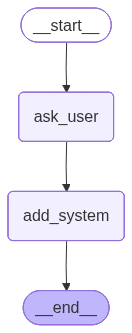

In [16]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
state_inital = {"dish": None, "steps":[], "ingredients":{}}

In [18]:
state = graph.invoke({"user_query": "", "recipe_data":state_inital})

[{'generated_text': '<s>[INST]\n    Tu es un chef étoilé. Pour le plat "riz aux carottes", donne:\n    1. Les ingrédients sous forme de dictionnaire Python (ex: {\'farine\': \'200g\'})\n    2. Les étapes de préparation sous forme de liste numérotée\n\n    Format de réponse STRICT:\n    ```python\n    {\n        "ingredients": {"ingredient1": "quantité", "ingredient2": "quantité"},\n        "steps": ["étape 1", "étape 2"]\n    }\n    ```[/INST]\n                                                                                                                                                                                                                                                                                                           '}]


### Here the input

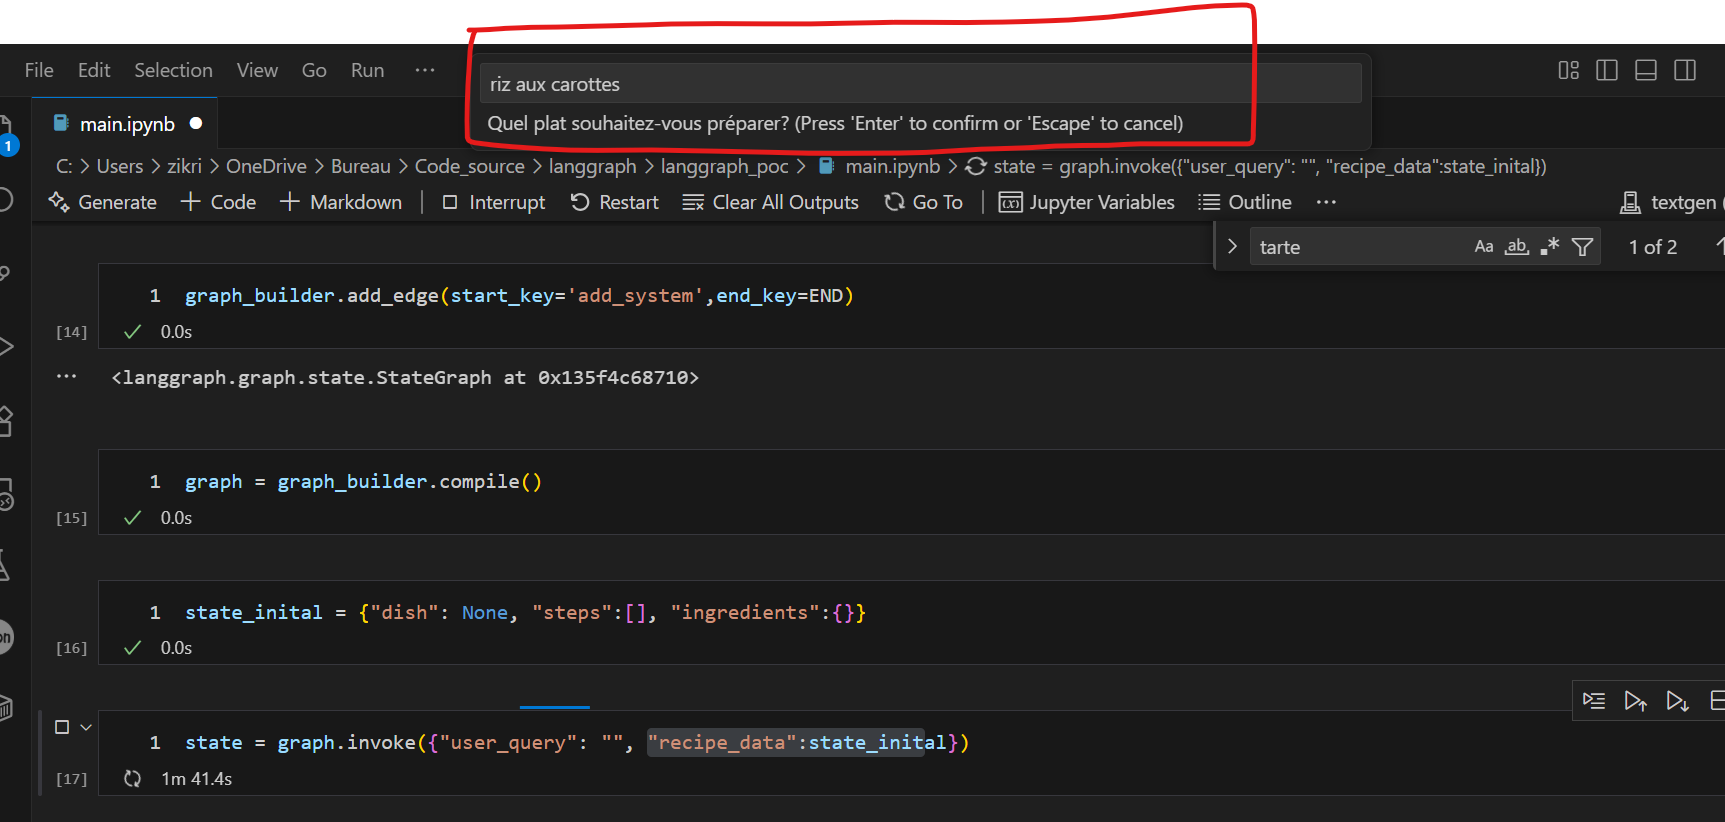

In [19]:
print(state)

{'recipe_data': RecipeData(dish='riz aux carottes', steps=None, ingredients=None), 'user_query': 'riz aux carottes'}
